### Librerias

In [1]:
import pandas as pd
import numpy as np
import re

from datetime import datetime, timedelta

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
from gensim.models.word2vec import Word2Vec

In [3]:
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#matplotlib.rcParams['figure.dpi'] = 800
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import random
random.seed(3)

In [5]:
import plotly.graph_objects as go
from plotly.offline import plot
import networkx as nx

In [6]:
pd.options.display.max_columns=None

### Adquisición de input

In [7]:
df_deal = pd.read_csv('../1.inputs/1.hubspot/todos-los-negocios.csv')
df_deal.shape

(745423, 131)

In [8]:
def unify_column_names(data):
    '''
    Change the names of the columns to lowercase,
    then remove question marks and replace
    whitespaces with "_"
    '''
    data.columns = data.columns.str.lower()
    data.columns = data.columns.str.replace('[^\w\s]','')
    data.columns = data.columns.str.replace(' ', '_')

In [9]:
unify_column_names(df_deal)

### Diccionario de nombres de certificaciones

|nombre|descripción|
|--|--|
|CIPELE | 'Certificacion Internacional Profesor de Español como Lengua Extranjera'|
|PCGPD | 'PM4R Professional Proyectos de Desarrollo'|
|PCGPISA | 'PM4R Agile Proyectos de Impacto Social'|
|PCGPDL | 'PM4R Leadership Proyectos de Desarrollo'|
|PCGPISL | 'PM4R Leadership Proyectos de Impacto Social'|
|PCGPDA | 'PM4R Agile Proyectos de Desarrollo'|
|PCGPIS | 'PM4R Professional Proyectos de Impacto Social'|
|MGPIS  | 'PM4R Expert Certificate Proyectos de Impacto Social'|
|MGPD | 'PM4R Expert Certificate Proyectos de Desarrollo'|
|MGPTS | 'PM4R Expert Certificate Proyectos de Turismo (Innovación, Tecnología y Sostenibilidad)'|
|MGPODS | 'PM4R Expert Certificate Proyectos de ODS'|
|MGPSC | 'PM4R Expert Certificate Proyectos de Smart Cities'|
|MGPIA | 'PM4R Expert Certificate Proyectos de Impacto Ambiental'|
|MGPCI | 'PM4R Expert Certificate Proyectos de Cooperación Internacional'|
|MGPER | 'PM4R Expert Certificate Proyectos de Energías Renovables'|
|MGPEDU | 'PM4R Expert Certificate Proyectos de Educación'|
|MGPEG | 'PM4R Expert Certificate Proyectos con Enfoque de Genero'|
|MGPTRR | 'PM4R Expert Certificate Proyectos de Tratamiento de Residuos y Reciclado.'|
|MGPASA | 'PM4R Expert Certificate Proyectos de Agua y Saneamiento'|
|MGPDEM | 'PM4R Expert Certificate Proyectos de Desarrollo Emprendedor'|
|MGPRSE | 'PM4R Expert Certificate Proyectos de Responsabilidad Social Empresaria'|
|MGPBIO | 'PM4R Expert Certificate Proyectos de Bioseguridad'|
|MGPINV | 'PM4R Expert Certificate Proyectos de Innovación'|
|MGPCC | 'PM4R Expert Certificate Proyectos de Cambio Climático'|
|MGPASO | 'PM4R Expert Certificate Proyectos de Agricultura Sostenible'|
|MGPTD | 'PM4R Expert Certificate Proyectos de Transformación digital'|
|MGPRRL | 'PM4R Expert Certificate Proyectos de Reconversión y Reinserción Laboral Futura'|
|MGPTGP | 'PM4R Expert Certificate Proyectos de Tecnología para a Gestión Publica'|
|PCCPMN | 'Professional Certificate: Consultor en Planes y Modelos de Negocio'|
|PCCEI | 'Professional Certificate: Consultor en Entrepreneurship & Innovation'|
|PEDIAC | 'Programa Ejecutivo: Dirección de Incubadoras, Aceleradoras y Centros de Desarrollo Emprendedor'|
|PCPE | 'Professional Certificate: Profesor en Emprendimiento e innovación'|
|PCCS | 'Professional Certificate: Creatividad de Impacto Social'|
|PCCI | 'Professional Certificate: Innovation Management'|
|PCDT | 'Professional Certificate: Design Thinking'|
|PCIAE | 'Professional Certificate: Incubación y Aceleración de Empresas'|
|PCIS | 'Professional Certificate: Innovación Social'|
|CSDLO | 'Curso Superior en Derecho: Litigación Oral'|
|CSDIA | 'Curso Superior en Derecho: Inteligencia Artificial y Derecho'|
|CSDLDB | 'Curso Superior en Derecho: Law & Digital Business'|
|CSDDC | 'Curso Superior en Derecho: Investigación y Prueba de Delitos Complejos'|
|CSDNNA | 'Curso Superior en Derecho: Derecho de Niños, Niñas y Adolescentes'|
|CSDAJVG | 'Curso Superior en Derecho: Abordaje Jurídico Actual de la Violencia de Género'|
|CSDCJI | 'Curso Superior en Derecho: Cooperación Jurídica Internacional'|
|CSDDI | 'Curso Superior en Derecho: Ciberdelitos'|
|CSDAJVF | 'Curso Superior en Derecho: Abordaje Jurídico Actual de la Violencia Familiar o Doméstica'|
|CSDLGTBI | 'Curso Superior en Derecho: Abordaje Jurídico y Multidisciplinar de los Derechos de las Personas LGTBI+|

### Procesamiento de texto

#### Elimino valores nulos

In [10]:
df_deal = df_deal[df_deal['cargo'].isna()==False]
df_deal.shape

(458478, 131)

#### Normalización

In [11]:
def normalize(data, column):
    '''
    Replace nulls and blanks with "no data" string.
    Converts strings to lowercase.
    Remove empty spaces at the beginning of each record.
    Remove punctuation marks, numbers and accents.
    Remove numbers in the string
    '''
    data[column].fillna('nulos', inplace=True)
    data[column].replace(r'^s*$', 'sin datos', regex=True, inplace=True)
    data[column] = data[column].apply(lambda x: x.lower())
    data[column] = data[column].apply(lambda x: x.lstrip())
    puntuacion = r'[,;.:¡!¿?@#$%&[\](){}<>~=+\-*/|\\_^`"\']'
    data[column] = data[column].apply(lambda x: re.sub(puntuacion, '', x))
    data[column] = data[column].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    data[column] = data[column].apply(lambda x: re.sub('\d+', '', x))

In [12]:
df_deal.cargo.value_counts(dropna=False)

Abogada                                                                 13671
Abogado                                                                 12121
Gerente                                                                 11912
Docente                                                                 11607
Director                                                                 9350
                                                                        ...  
administración turística                                                    1
Facilitador de Participación                                                1
ASESOR CONSULTOR LABORAL                                                    1
Business Manager for Ecuador                                                1
Abogada, diplomada en derechos humanos de niñas niños y adolescented        1
Name: cargo, Length: 93786, dtype: int64

In [13]:
normalize(df_deal, 'cargo')

In [14]:
df_deal.cargo.value_counts(dropna=False)

abogada                                                                16500
docente                                                                16217
abogado                                                                15780
gerente                                                                14694
director                                                               10686
                                                                       ...  
gestor de cambio                                                           1
director de canal comercial                                                1
control gestion ssoma para la mineria                                      1
analista compras y logistica                                               1
abogada diplomada en derechos humanos de ninas ninos y adolescented        1
Name: cargo, Length: 77257, dtype: int64

#### Stop words en español

In [15]:
from nltk.corpus import stopwords

In [16]:
# Obtención de listado de stopwords del español
# ==============================================================================
stop_words = list(stopwords.words('spanish'))
# Se añade la stoprword: amp, ax, ex
# stop_words.extend("sfsdf")
stop_words.append('sfsdf')
print(stop_words[:10])

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se']


In [17]:
def delete_stopwords(texto, listado):
    return ' '.join([word for word in texto.split(' ') if word not in listado])

In [18]:
df_deal['cargo'] = df_deal['cargo'].apply(lambda x: delete_stopwords(x, stop_words))

In [19]:
df_deal.cargo.value_counts(dropna=False)

abogada                                                        16520
docente                                                        16236
abogado                                                        15789
gerente                                                        14738
director                                                       10713
                                                               ...  
consultora coaching                                                1
ingeniero logistica                                                1
superintendente  proyectos                                         1
secretaria tesorera coordinadora                                   1
abogada diplomada derechos humanos ninas ninos adolescented        1
Name: cargo, Length: 73533, dtype: int64

#### Tokenizo la variable cargo
- Creo una lista con las palabras que forman el contenido de la descripción de cargo

In [20]:
def deal_ids_tokenizar(texto):
    '''
    '''
    nuevo_texto = str(texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    
    return(nuevo_texto)

In [21]:
df_deal['cargo_tokenizado'] = df_deal['cargo'].apply(lambda x: deal_ids_tokenizar(x))
df_deal[['cargo', 'cargo_tokenizado']].head(100)

,cargo,cargo_tokenizado
18,docente educador,"[docente, educador]"
35,directora,[directora]
40,director tecnico administrativo,"[director, tecnico, administrativo]"
55,asosiado,[asosiado]
81,director,[director]
...,...,...
706,tecnico gestion riesgo,"[tecnico, gestion, riesgo]"
711,medico general,"[medico, general]"
712,,[]
718,directora ypresidenta proyecto social,"[directora, ypresidenta, proyecto, social]"


#### Armo una lista con las palabras que encontramos en la variable Cargo

In [22]:
train_data = df_deal.cargo_tokenizado.values.tolist()

In [23]:
train_data[:20]

[['docente', 'educador'],
 ['directora'],
 ['director', 'tecnico', 'administrativo'],
 ['asosiado'],
 ['director'],
 ['jefe', 'bienestar', 'personas'],
 ['chef', 'barista', 'capacitacion'],
 ['especialista'],
 ['ceo'],
 ['director', 'productor'],
 ['docente', 'carrera', 'administracion', 'empresas'],
 ['management'],
 ['gerente', 'microfinanzas'],
 ['abogado'],
 ['cofounderproducer'],
 ['porteria'],
 ['independiente'],
 ['consultora'],
 ['coordinadora', 'proyecto'],
 ['profesional']]

#### Modelado

In [24]:
#!pip install gensim

In [25]:
model = Word2Vec()

In [26]:
model.build_vocab(train_data)

In [27]:
%%time
model.train(train_data, total_examples=model.corpus_count, epochs =model.epochs)

CPU times: user 3.18 s, sys: 32 ms, total: 3.21 s
Wall time: 1.74 s


(2608620, 3878235)

In [28]:
model.wv.most_similar(['abogado'], topn=20)

[('abogada', 0.8133281469345093),
 ('abigado', 0.7826945185661316),
 ('abogago', 0.740146279335022),
 ('abogadoo', 0.7069364786148071),
 ('aboga', 0.7064356207847595),
 ('abigada', 0.700019121170044),
 ('civilista', 0.6985772252082825),
 ('empresario', 0.6946550607681274),
 ('ab', 0.6819917559623718),
 ('mediador', 0.6715239882469177),
 ('distribuidor', 0.6689445972442627),
 ('profesion', 0.6630975008010864),
 ('litigante', 0.6621942520141602),
 ('conciliador', 0.6590607762336731),
 ('adscrito', 0.6577285528182983),
 ('reforestador', 0.6516144275665283),
 ('arbitro', 0.6501240134239197),
 ('herbalife', 0.6490527987480164),
 ('cooperativista', 0.6435432434082031),
 ('procesalista', 0.6406923532485962)]

In [29]:
model.wv.most_similar(['docente'], topn=20)

[('profesor', 0.8803226947784424),
 ('profesora', 0.8310800194740295),
 ('prof', 0.8029908537864685),
 ('catedratico', 0.7893818020820618),
 ('maestra', 0.7881132364273071),
 ('copnsultor', 0.7548401951789856),
 ('abogadodocente', 0.740331768989563),
 ('profedor', 0.728711724281311),
 ('extension', 0.7260993719100952),
 ('mtro', 0.7244672179222107),
 ('cientifico', 0.7242628931999207),
 ('profesorado', 0.7194010615348816),
 ('doctoral', 0.7137004137039185),
 ('catedratica', 0.6969544291496277),
 ('conicet', 0.6899867057800293),
 ('grado', 0.6889031529426575),
 ('titulo', 0.6875708699226379),
 ('adultos', 0.676383376121521),
 ('tutor', 0.6760314702987671),
 ('completo', 0.6752163767814636)]

In [30]:
model.wv.most_similar(['gerente'], topn=20)

[('gte', 0.9085354804992676),
 ('gerenta', 0.8580358624458313),
 ('dir', 0.8525438904762268),
 ('subgerente', 0.8409017324447632),
 ('cordinador', 0.8053162097930908),
 ('subdirector', 0.7991655468940735),
 ('gernete', 0.7952345609664917),
 ('dorector', 0.7942754030227661),
 ('cordinadora', 0.7719659209251404),
 ('diector', 0.7716428637504578),
 ('enc', 0.7649437189102173),
 ('gerenre', 0.7492800951004028),
 ('direcyor', 0.747347354888916),
 ('coordinado', 0.7461850047111511),
 ('superintendente', 0.7428247332572937),
 ('coordinar', 0.7390512228012085),
 ('arquitectonicos', 0.7379099130630493),
 ('amdc', 0.7373978495597839),
 ('councel', 0.7361538410186768),
 ('resp', 0.7342877388000488)]

#### Armamos una lista con los elementos de la variable cargo

In [31]:
df_cargo = df_deal[['cargo', 'cargo_tokenizado']]
df_cargo.shape

(458478, 2)

In [32]:
cargo_tidy = df_cargo.explode(column='cargo_tokenizado')

In [33]:
items_for_jobs = cargo_tidy['cargo_tokenizado'].unique().tolist()

In [34]:
#items_for_jobs = cargo_tidy.cargo_tokenizado.values.tolist()

In [35]:
len(items_for_jobs)

26233

In [36]:
# cargo_list = cargo_list[cargo_list >= 100].index.tolist()

In [37]:
words, vectors = [],[]
for item in items_for_jobs:
    try:
        vectors.append(model.wv.get_vector(item))
        words.append(item)
    except KeyError:
        print(f'Word {item} not in vocab -- panic!')

Word asosiado not in vocab -- panic!
Word porteria not in vocab -- panic!
Word jjjk not in vocab -- panic!
Word cedemun not in vocab -- panic!
Word reded not in vocab -- panic!
Word dirigenta not in vocab -- panic!
Word viuntaria not in vocab -- panic!
Word estilo not in vocab -- panic!
Word nan not in vocab -- panic!
Word ypresidenta not in vocab -- panic!
Word mudevisa not in vocab -- panic!
Word mtc not in vocab -- panic!
Word brocker not in vocab -- panic!
Word borja not in vocab -- panic!
Word desastre not in vocab -- panic!
Word geresa not in vocab -- panic!
Word bendiciones not in vocab -- panic!
Word pris not in vocab -- panic!
Word onboarding not in vocab -- panic!
Word apfa not in vocab -- panic!
Word ehpm not in vocab -- panic!
Word atraves not in vocab -- panic!
Word job not in vocab -- panic!
Word controlar not in vocab -- panic!
Word hall not in vocab -- panic!
Word quiche not in vocab -- panic!
Word currently not in vocab -- panic!
Word electravila not in vocab -- panic!

In [38]:
vectors[0]

array([-0.7461793 ,  0.08964682,  0.26678994, -0.42864996,  0.86810046,
       -0.07558927, -0.8171002 ,  0.02720401, -0.45183092,  0.4784698 ,
       -0.7180836 , -0.1583799 ,  0.20282231,  0.25567326,  0.2930481 ,
       -0.5913349 ,  0.08347367, -0.46859086, -0.21424058, -0.7675043 ,
       -0.15868478,  0.12575516,  0.2962605 , -0.8302392 ,  0.09824447,
       -0.44055185,  0.21051244,  0.44567943, -0.4287055 , -0.18351904,
        0.353035  , -0.5647699 , -0.06193753,  0.00964353, -0.55132073,
        0.4714605 ,  0.06970862, -0.9005184 , -0.4353705 ,  0.19989581,
        0.10988843, -0.33247015,  0.64387715, -0.43013543,  0.46015143,
        0.33240542, -0.94541126, -0.13538407,  0.49815387, -0.5387667 ,
        0.38125256, -0.0846253 , -0.42928496,  0.7539882 , -0.53572106,
        0.14621039,  0.4981957 ,  0.32993528,  0.3898429 , -0.27660248,
        0.40570986, -0.74767035,  0.18096596,  0.8121185 ,  0.04999123,
        0.72672564,  0.4939618 ,  0.12505363, -0.6753848 ,  1.77

#### similitud del coseno

In [39]:
sims = cosine_similarity(vectors, vectors)
sims.shape

(5770, 5770)

In [40]:
for i in range(len(vectors)):
    for j in range(len(vectors)):
        if i<=j:
            sims[i,j] = False

In [41]:
k = 20
indices = list(range(len(vectors)))

In [42]:
random.shuffle(indices)

In [43]:
indices = indices[:k]

In [44]:
small_vectors = [vectors[i] for i in indices]
small_words = [words[i] for i in indices]

In [45]:
small_sims = cosine_similarity(small_vectors, small_vectors)

In [46]:
for x in range(len(small_vectors)):
    small_sims[x,x] = 0

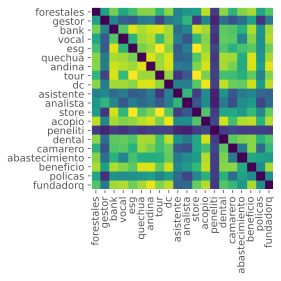

In [47]:
fig, ax = plt.subplots()
im = ax.imshow(small_sims)

ax.set_xticks(np.arange(len(small_vectors)))
ax.set_yticks(np.arange(len(small_vectors)))

ax.set_xticklabels(small_words)
ax.set_yticklabels(small_words)
ax.grid(False)

plt.setp(ax.get_xticklabels(), rotation=90)

fig.tight_layout()
plt.show()

In [48]:
'forestales' in words

True

#### Building and Visualizing Interactive Network Graph

In [69]:
indices_2 = np.argwhere(sims > 0.65)
indices_2[0]

array([7, 1])

In [70]:
G = nx.Graph()

for index in indices_2:
    G.add_edge(words[index[0]], words[index[1]], weight=sims[index[0],index[1]])

In [71]:
weight_values = nx.get_edge_attributes(G, 'weight')

In [ ]:
positions = nx.spring_layout(G)

In [ ]:
nx.set_node_attributes(G,name='position', values=positions)

In [ ]:
searches = []

In [ ]:
edge_x = []
edge_y = []
weights = []
ave_x, ave_y = [], []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['position']
    x1, y1 = G.nodes[edge[1]]['position']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    ave_x.append(np.mean([x0, x1]))
    ave_y.append(np.mean([y0, y1]))
    weights.append(f'{edge[0]}, {edge[1]}: {weight_values[(edge[0], edge[1])]}')

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    opacity=0.7,
    line=dict(width=2, color='White'),
    hoverinfo='text',
    mode='lines')

edge_trace.text = weights


node_x = []
node_y = []
sizes = []
for node in G.nodes():
    x, y = G.nodes[node]['position']
    node_x.append(x)
    node_y.append(y)
    if node in searches:
        sizes.append(50)
    else:
        sizes.append(15)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        line=dict(color='White'),
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Picnic',
        reversescale=False,
        color=[],
        opacity=0.9,
        size=sizes,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2
    )
)

invisible_similarity_trace = go.Scatter(
    x=ave_x, y=ave_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        color=[],
        opacity=0,
    )
)

invisible_similarity_trace.text=weights

In [ ]:
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append(adjacencies[0])

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [ ]:
fig = go.Figure(
    data=[edge_trace, node_trace, invisible_similarity_trace],
    layout=go.Layout(
        title='Network Graph of Word Embeddings',
        template='plotly_dark',
        titlefont_size=20,
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20,l=5,r=5,t=40),
        annotations=[
            dict(
                text="Adapted from: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                showarrow=False,
                xref="paper", yref="paper",
                x=0.005, y=-0.002 ) 
        ],
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
)

plot(fig)